# Product Category, Profitability, and Trends Analysis

## Data Inspection

In [2]:
import pandas as pd

df = pd.read_csv("dataset/Clothing Sales Data.csv")

#Preview
df.head()

,saleID,saleDate,productID,productName,productCategory,productColor,productSize,quantity,unitPrice,costPrice,...,totalCost,customerID,customerName,location,locationLatitude,locationLongitude,salespersonID,salespersonName,status,salesChannel
0,S00001,2023-09-01 21:43:00,P1000,Women's_000,Women's Dresses,Red,XXL,2,1572.76,1154.01,...,2308.02,C20000,Vishal_0000,Tiruchirappalli,10.7905,78.7047,SP114,Salesperson_14,Pending,online
1,S00002,2023-03-06 15:20:00,P1001,Women's_001,Women's Dresses,Maroon,XS,1,247.34,220.37,...,220.37,C20001,Sathish_0001,Erode,11.3400,77.7172,SP102,Salesperson_2,Paid,online
2,S00003,2024-06-25 12:10:00,P1002,Women's_002,Women's Dresses,Black,S,2,1620.21,1269.43,...,2538.86,C20002,Anu_0002,Chennai,13.0827,80.2707,SP135,Salesperson_35,Pending,in-store
3,S00004,2023-01-05 10:31:00,P1003,Kurta_003,Kurta,Black,L,4,520.84,358.15,...,1432.60,C20003,Sathish_0003,Salem,11.6643,78.1460,SP100,Salesperson_0,Pending,in-store
4,S00005,2023-08-27 15:47:00,P1004,Kurta_004,Kurta,Yellow,M,1,1079.66,966.26,...,966.26,C20004,Kavin_0004,Tiruchirappalli,10.7905,78.7047,SP148,Salesperson_48,Returned,in-store


In [3]:
df.info()
 # summary of all columns
df.describe(include="all").T 

# Missing values check
print("Missing Values:")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   saleID             10000 non-null  object 
 1   saleDate           10000 non-null  object 
 2   productID          10000 non-null  object 
 3   productName        10000 non-null  object 
 4   productCategory    10000 non-null  object 
 5   productColor       10000 non-null  object 
 6   productSize        10000 non-null  object 
 7   quantity           10000 non-null  int64  
 8   unitPrice          10000 non-null  float64
 9   costPrice          10000 non-null  float64
 10  totalAmount        10000 non-null  float64
 11  totalCost          10000 non-null  float64
 12  customerID         10000 non-null  object 
 13  customerName       10000 non-null  object 
 14  location           10000 non-null  object 
 15  locationLatitude   10000 non-null  float64
 16  locationLongitude  1000

saleID               0
saleDate             0
productID            0
productName          0
productCategory      0
productColor         0
productSize          0
quantity             0
unitPrice            0
costPrice            0
totalAmount          0
totalCost            0
customerID           0
customerName         0
location             0
locationLatitude     0
locationLongitude    0
salespersonID        0
salespersonName      0
status               0
salesChannel         0
dtype: int64

## Data Preprocessing 

### Feature Engineering 

In [4]:
 # 1. Convert saleDate to datetime
df["saleDate"] = pd.to_datetime(df["saleDate"])

# 2. Extract year and month (good for trend plots & grouping)
df["year"] = df["saleDate"].dt.year
df["month"] = df["saleDate"].dt.month
df["year_month"] = df["saleDate"].dt.to_period("M").astype(str)

# 3. Revenue, cost, profit, margin
# revenue is already totalAmount; cost is totalCost (Being explicit for SQL queries)
df["revenue"] = df["totalAmount"]
df["cost"] = df["totalCost"]
df["profit"] = df["revenue"] - df["cost"]

# Avoid division by zero for margin
df["margin_pct"] = df["profit"] / df["revenue"]

In [5]:
df.to_csv("clothing_sales_clean.csv", index=False)

## Connecting to a local SQL database

In [6]:
import sqlite3

# Create / connect to a local SQLite DB file
conn = sqlite3.connect("clothing_sales.db")

# Write the dataframe to a table called 'sales'
df.to_sql("sales", conn, if_exists="replace", index=False)

10000

## SQL Queries

### 1. Category-level Profitability

This query helps identify which product categories drive the most business value by comparing revenue, profit, margin, and units sold. These are foundational KPIs for retail planning because they show:
- Which categories generate the highest sales
- Which categories are truly profitable (not always the same!)
- Where planners should increase/decrease inventory allocation
- Which categories have too many/too few SKUs


In [7]:
query_category_profit = """
SELECT
    productCategory,
    COUNT(DISTINCT productID) AS num_skus,
    SUM(quantity) AS total_units_sold,
    SUM(revenue) AS total_revenue,
    SUM(cost) AS total_cost,
    SUM(profit) AS total_profit,
    AVG(margin_pct) AS avg_margin_pct
FROM sales
GROUP BY productCategory
ORDER BY total_revenue DESC;
"""

category_profit_df = pd.read_sql_query(query_category_profit, conn)
category_profit_df

,productCategory,num_skus,total_units_sold,total_revenue,total_cost,total_profit,avg_margin_pct
0,Kurta,470,2569,3566053.06,2659356.88,906696.18,0.250515
1,Sportswear,479,2599,3545695.49,2661691.76,884003.73,0.252557
2,Jeans,467,2560,3475597.29,2590287.24,885310.05,0.252986
3,Sarees,469,2501,3409485.50,2551631.45,857854.05,0.249700
4,T-Shirts,470,2569,3388823.20,2553677.58,835145.62,0.246646
5,Men's Shirts,463,2456,3355149.02,2517482.15,837666.87,0.250544
6,Women's Dresses,461,2392,3217048.49,2413546.41,803502.08,0.251072
7,Kid's Wear,458,2403,3202646.46,2413520.46,789126.00,0.245143


### 2. Monthly Trend Analysis (Seasonality and Growth)

This query uncovers time-based performance trends, which is crucial for forecasting, seasonal planning, and understanding demand cycles.

It answers questions like:
- When do sales peak?
- Is revenue growing month-over-month?
- Are there seasonal patterns (e.g., winter outerwear spike, summer dresses spike)?
- Are profits increasing or shrinking?

In [8]:
query_monthly_trends = """
SELECT
    year_month,
    SUM(revenue) AS revenue,
    SUM(quantity) AS units_sold,
    SUM(profit) AS profit
FROM sales
GROUP BY year_month
ORDER BY year_month;
"""

monthly_trends_df = pd.read_sql_query(query_monthly_trends, conn)
monthly_trends_df.head()

,year_month,revenue,units_sold,profit
0,2023-01,1260987.84,952,324580.70
1,2023-02,1034936.40,791,254925.77
2,2023-03,1243177.65,954,317562.53
3,2023-04,1207111.76,899,296791.59
4,2023-05,1207565.14,917,310196.05


### 3. Top and Bottom SKU performs

This query tells us which individual products (SKUs) are outperforming or underperforming.

Why this matters?
- Top SKUs inform future buying decisions
- Underperforming SKUs may be candidates for markdowns, discontinuation, or redesign
- Helps planners and merchants identify hero products and deadstock
- Highlights whether certain product categories depend heavily on a few SKUs



In [9]:
query_top_skus = """
SELECT
    productID,
    productName,
    productCategory,
    SUM(quantity) AS units_sold,
    SUM(revenue) AS total_revenue,
    SUM(profit) AS total_profit
FROM sales
GROUP BY productID, productName, productCategory
ORDER BY total_revenue DESC
LIMIT 10;
"""

top_skus_df = pd.read_sql_query(query_top_skus, conn)
top_skus_df.head()

,productID,productName,productCategory,units_sold,total_revenue,total_profit
0,P1090,Jeans_090,Jeans,24,46065.45,12909.07
1,P1469,Men's_469,Men's Shirts,25,32506.06,8774.57
2,P1352,Kurta_352,Kurta,18,31830.44,8963.55
3,P1214,T-Shirts_214,T-Shirts,17,31277.02,8194.50
4,P1326,Kid's_326,Kid's Wear,19,31127.39,8238.61


In [10]:
query_bottom_skus = """
SELECT
    productID,
    productName,
    productCategory,
    SUM(quantity) AS units_sold,
    SUM(revenue) AS total_revenue,
    SUM(profit) AS total_profit
FROM sales
GROUP BY productID, productName, productCategory
ORDER BY total_revenue ASC
LIMIT 10;
"""

bottom_skus_df = pd.read_sql_query(query_bottom_skus, conn)
bottom_skus_df.head()

,productID,productName,productCategory,units_sold,total_revenue,total_profit
0,P1276,T-Shirts_276,T-Shirts,1,200.55,70.08
1,P1417,Kurta_417,Kurta,1,204.84,37.84
2,P1369,Men's_369,Men's Shirts,1,217.46,49.62
3,P1186,Women's_186,Women's Dresses,1,228.97,84.99
4,P1110,Jeans_110,Jeans,1,237.63,43.66


### 4. Sales Channel Analysis (Online vs In-Store)

This query breaks down performance by sales channel, i.e. Which channel drives the most revenue. This helps detemrine:
- Whether online or in-store customers buy differently
- How margin compares between channels
- Whether the company should invest more into e-commerce or physical stores


In [11]:
query_channel_analysis = """
SELECT
    salesChannel,
    SUM(revenue) AS total_revenue,
    SUM(quantity) AS total_units,
    SUM(profit) AS total_profit,
    AVG(margin_pct) AS avg_margin
FROM sales
GROUP BY salesChannel;
"""

channel_analysis_df = pd.read_sql_query(query_channel_analysis, conn)
channel_analysis_df.head()

,salesChannel,total_revenue,total_units,total_profit,avg_margin
0,in-store,13720665.16,10007,3462539.25,0.251465
1,mobile_app,3962699.60,2999,991026.41,0.250221
2,online,7973725.52,5921,1962791.81,0.246779
3,third-party,1503408.23,1122,382947.11,0.251852


### 5. Category-by-Channel (Cross-Analysis)

This query shows which categories sell best online vs in-store. 

In [12]:
query_cat_channel = """
SELECT
    productCategory,
    salesChannel,
    SUM(quantity) AS units_sold,
    SUM(revenue) AS total_revenue,
    SUM(profit) AS total_profit,
    AVG(margin_pct) AS avg_margin
FROM sales
GROUP BY productCategory, salesChannel
ORDER BY productCategory, total_revenue DESC;
"""

cat_channel_df = pd.read_sql_query(query_cat_channel, conn)
cat_channel_df.head()

,productCategory,salesChannel,units_sold,total_revenue,total_profit,avg_margin
0,Jeans,in-store,1301,1791270.70,461333.58,0.253094
1,Jeans,online,691,927761.36,224068.42,0.247651
2,Jeans,mobile_app,415,581450.29,153191.91,0.257030
3,Jeans,third-party,153,175114.94,46716.14,0.264811
4,Kid's Wear,in-store,1220,1645543.09,409331.87,0.247440


### 6. Return and Refund Patterns

In [13]:
query_returns = """
SELECT
    productCategory,
    status,
    COUNT(*) AS num_transactions,
    SUM(revenue) AS revenue_impact
FROM sales
WHERE status IN ('Returned', 'Cancelled')
GROUP BY productCategory, status
ORDER BY revenue_impact DESC;
"""

returns_df = pd.read_sql_query(query_returns, conn)
returns_df.head()

,productCategory,status,num_transactions,revenue_impact
0,Jeans,Cancelled,282,810532.12
1,Sarees,Returned,261,748812.46
2,T-Shirts,Cancelled,274,748097.89
3,Kurta,Returned,256,747689.12
4,Sportswear,Returned,271,717974.99


## Margin Contribution Analysis 

The goal is to identify which products contribute most of profit


In [14]:
query_sku_profit = """
SELECT
    productID,
    productName,
    productCategory,
    SUM(revenue) AS total_revenue,
    SUM(profit)  AS total_profit,
    SUM(quantity) AS total_units
FROM sales
GROUP BY productID, productName, productCategory
HAVING total_profit IS NOT NULL
ORDER BY total_profit DESC;
"""

sku_profit_df = pd.read_sql_query(query_sku_profit, conn)
sku_profit_df.head()

,productID,productName,productCategory,total_revenue,total_profit,total_units
0,P1090,Jeans_090,Jeans,46065.45,12909.07,24
1,P1352,Kurta_352,Kurta,31830.44,8963.55,18
2,P1469,Men's_469,Men's Shirts,32506.06,8774.57,25
3,P1326,Kid's_326,Kid's Wear,31127.39,8238.61,19
4,P1214,T-Shirts_214,T-Shirts,31277.02,8194.50,17


In [15]:
# Sort by profit descending (already sorted but ensure)
sku_profit_df = sku_profit_df.sort_values("total_profit", ascending=False)

# Cumulative profit and share
sku_profit_df["cum_profit"] = sku_profit_df["total_profit"].cumsum()
total_profit_all = sku_profit_df["total_profit"].sum()
sku_profit_df["cum_profit_pct"] = sku_profit_df["cum_profit"] / total_profit_all

# Cumulative SKU share
sku_profit_df["sku_rank"] = range(1, len(sku_profit_df) + 1)
sku_profit_df["sku_rank_pct"] = sku_profit_df["sku_rank"] / len(sku_profit_df)

sku_profit_df.head()

,productID,productName,productCategory,total_revenue,total_profit,total_units,cum_profit,cum_profit_pct,sku_rank,sku_rank_pct
0,P1090,Jeans_090,Jeans,46065.45,12909.07,24,12909.07,0.001899,1,0.000268
1,P1352,Kurta_352,Kurta,31830.44,8963.55,18,21872.62,0.003217,2,0.000535
2,P1469,Men's_469,Men's Shirts,32506.06,8774.57,25,30647.19,0.004507,3,0.000803
3,P1326,Kid's_326,Kid's Wear,31127.39,8238.61,19,38885.80,0.005719,4,0.001070
4,P1214,T-Shirts_214,T-Shirts,31277.02,8194.50,17,47080.30,0.006924,5,0.001338


In [16]:
top_20_mask = sku_profit_df["sku_rank_pct"] <= 0.2
top_20_skus = sku_profit_df[top_20_mask]

top_20_share = top_20_skus["total_profit"].sum() / total_profit_all
top_20_share

np.float64(0.4383772994619988)

In [17]:
top_20_by_cat = (
    top_20_skus
    .groupby("productCategory")["total_profit"]
    .sum()
    .sort_values(ascending=False)
)
top_20_by_cat

productCategory
Kurta              455421.54
Jeans              427872.57
Sportswear         383714.04
Sarees             369601.81
Men's Shirts       366693.35
T-Shirts           354827.96
Women's Dresses    312323.97
Kid's Wear         310205.54
Name: total_profit, dtype: float64

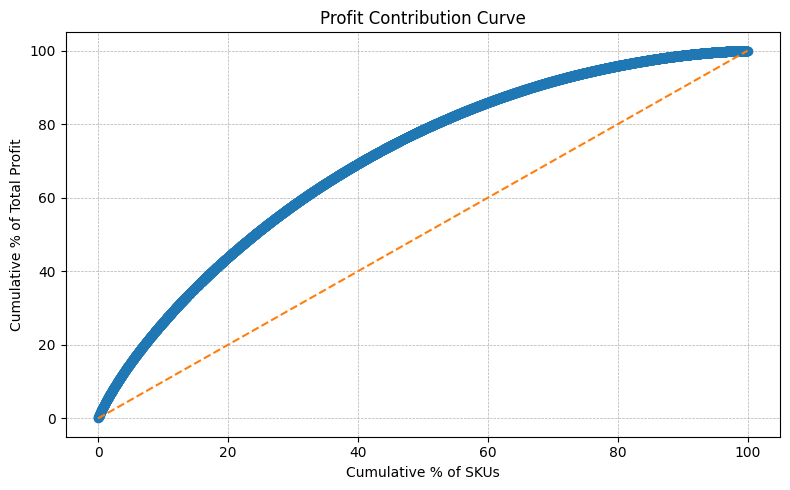

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(sku_profit_df["sku_rank_pct"] * 100,
         sku_profit_df["cum_profit_pct"] * 100,
         marker="o", linewidth=1)

plt.plot([0, 100], [0, 100], linestyle="--")

plt.xlabel("Cumulative % of SKUs")
plt.ylabel("Cumulative % of Total Profit")
plt.title("Profit Contribution Curve")

plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
# plt.savefig("pareto_profit_sku.png", dpi=300)
plt.show()

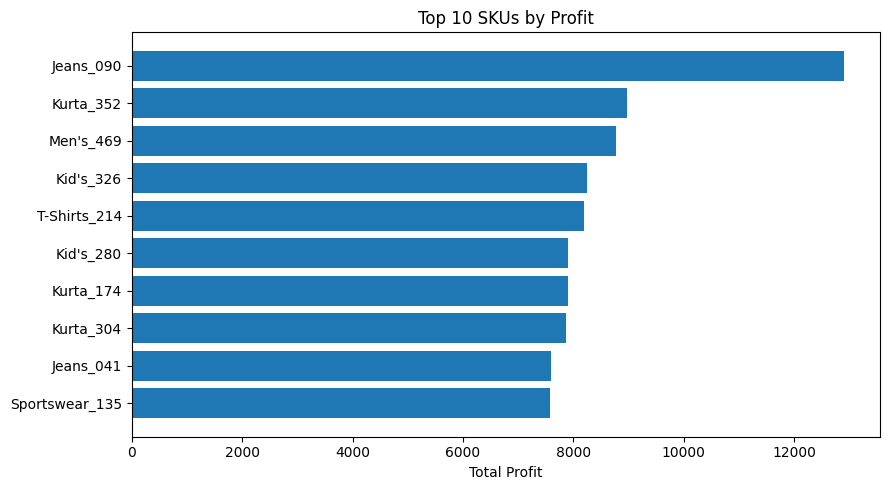

In [19]:
top10_profit = sku_profit_df.head(10)

plt.figure(figsize=(9, 5))
plt.barh(top10_profit["productName"], top10_profit["total_profit"])
plt.gca().invert_yaxis()

plt.xlabel("Total Profit")
plt.title("Top 10 SKUs by Profit")
plt.tight_layout()
# plt.savefig("top10_sku_profit.png", dpi=300)
plt.show()

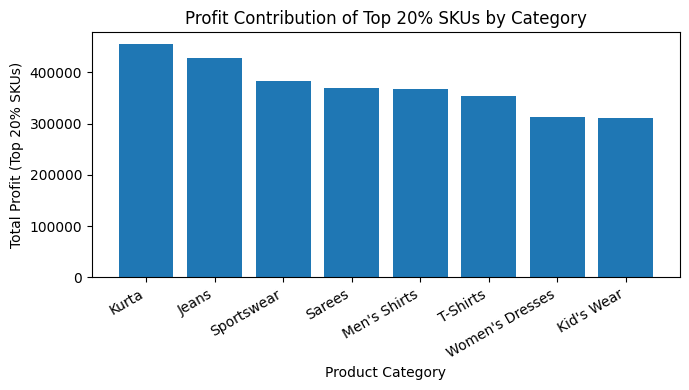

In [20]:
top_20_by_cat_plot = top_20_by_cat.reset_index()

plt.figure(figsize=(7, 4))
plt.bar(top_20_by_cat_plot["productCategory"],
        top_20_by_cat_plot["total_profit"])

plt.xlabel("Product Category")
plt.ylabel("Total Profit (Top 20% SKUs)")
plt.title("Profit Contribution of Top 20% SKUs by Category")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
# plt.savefig("top20_sku_profit_by_category.png", dpi=300)
plt.show()

## RFM Analysis (Recency, Frequency, Monetary)
The goal is to segment customers by behaviour i.e. “Champions”, “At Risk”, etc.

In [21]:
query_customer_sales = """
SELECT
    customerID,
    customerName,
    saleDate,
    revenue
FROM sales
WHERE status = 'Paid';
"""

cust_sales_df = pd.read_sql_query(query_customer_sales, conn)
cust_sales_df["saleDate"] = pd.to_datetime(cust_sales_df["saleDate"])
cust_sales_df.head()

,customerID,customerName,saleDate,revenue
0,C20001,Sathish_0001,2023-03-06 15:20:00,247.34
1,C20006,Ravi_0006,2024-09-19 19:18:00,1462.12
2,C20027,Meena_0027,2024-02-17 18:31:00,2467.00
3,C20028,Diya_0028,2024-03-12 19:14:00,8188.88
4,C20034,Vishal_0034,2024-10-09 21:33:00,634.03


In [22]:
import numpy as np

snapshot_date = cust_sales_df["saleDate"].max() + pd.Timedelta(days=1)

rfm = (
    cust_sales_df
    .groupby("customerID")
    .agg(
        last_purchase=("saleDate", "max"),
        frequency=("saleDate", "count"),
        monetary=("revenue", "sum")
    )
    .reset_index()
)

rfm["recency_days"] = (snapshot_date - rfm["last_purchase"]).dt.days

rfm.head()

,customerID,last_purchase,frequency,monetary,recency_days
0,C20001,2023-03-06 15:20:00,1,247.34,586
1,C20006,2024-09-19 19:18:00,1,1462.12,23
2,C20027,2024-02-17 18:31:00,1,2467.00,238
3,C20028,2024-03-12 19:14:00,1,8188.88,214
4,C20034,2024-10-09 21:33:00,1,634.03,3


In [23]:
# Lower recency_days = more recent = better
rfm["R_score"] = pd.qcut(rfm["recency_days"], 4, labels=[4,3,2,1])

# Higher frequency/monetary = better
rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_score"] = pd.qcut(rfm["monetary"].rank(method="first"), 4, labels=[1,2,3,4])

rfm["RFM_score"] = rfm["R_score"].astype(str) + rfm["F_score"].astype(str) + rfm["M_score"].astype(str)
rfm.head()

,customerID,last_purchase,frequency,monetary,recency_days,R_score,F_score,M_score,RFM_score
0,C20001,2023-03-06 15:20:00,1,247.34,586,1,1,1,111
1,C20006,2024-09-19 19:18:00,1,1462.12,23,4,1,2,412
2,C20027,2024-02-17 18:31:00,1,2467.00,238,3,1,3,313
3,C20028,2024-03-12 19:14:00,1,8188.88,214,3,1,4,314
4,C20034,2024-10-09 21:33:00,1,634.03,3,4,1,1,411


In [24]:
def segment_customer(row):
    r, f, m = int(row["R_score"]), int(row["F_score"]), int(row["M_score"])
    if r >= 3 and f >= 3 and m >= 3:
        return "Champions"
    elif r >= 3 and f >= 2:
        return "Loyal"
    elif r <= 2 and f <= 2 and m <= 2:
        return "At Risk"
    else:
        return "Potential / Regular"

rfm["segment"] = rfm.apply(segment_customer, axis=1)

rfm["segment"].value_counts()

segment
Potential / Regular    983
Loyal                  490
At Risk                255
Champions              234
Name: count, dtype: int64

In [25]:
segment_summary = (
    rfm
    .groupby("segment")
    .agg(
        customers=("customerID", "count"),
        avg_recency=("recency_days", "mean"),
        avg_freq=("frequency", "mean"),
        avg_monetary=("monetary", "mean")
    )
    .sort_values("avg_monetary", ascending=False)
)

segment_summary

,customers,avg_recency,avg_freq,avg_monetary
segment,,,,
Champions,234,169.350427,1.0,4140.496368
Potential / Regular,983,402.820956,1.0,3157.061913
Loyal,490,166.142857,1.0,1987.996735
At Risk,255,490.392157,1.0,1153.533412


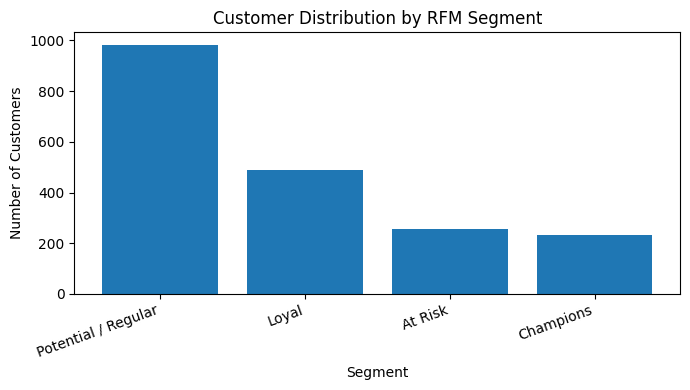

In [26]:
segment_counts = rfm["segment"].value_counts().reset_index()
segment_counts.columns = ["segment", "customers"]

plt.figure(figsize=(7, 4))
plt.bar(segment_counts["segment"], segment_counts["customers"])

plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by RFM Segment")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
# plt.savefig("rfm_segment_counts.png", dpi=300)
plt.show()

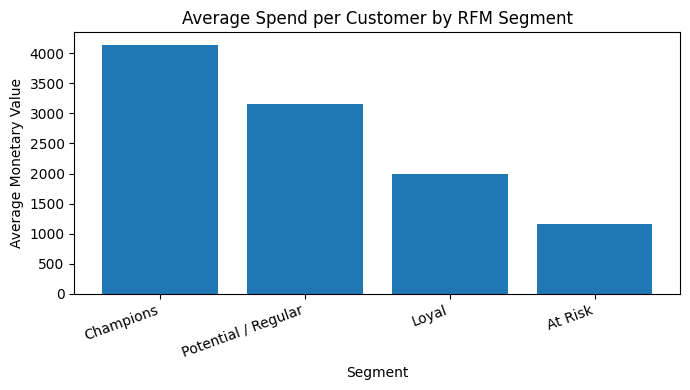

In [27]:
segment_monetary = (
    rfm.groupby("segment")["monetary"]
    .mean()
    .reset_index()
    .sort_values("monetary", ascending=False)
)

plt.figure(figsize=(7, 4))
plt.bar(segment_monetary["segment"], segment_monetary["monetary"])

plt.xlabel("Segment")
plt.ylabel("Average Monetary Value")
plt.title("Average Spend per Customer by RFM Segment")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
# plt.savefig("rfm_avg_monetary_by_segment.png", dpi=300)
plt.show()

## Markdown Efficiency (Using Simualted Discount Scenarios)

Since the dataset does not contain discounted items, the goal is to simulate discounts and see how category margins respond.

In [28]:
query_cat_baseline = """
SELECT
    productCategory,
    SUM(quantity) AS total_units,
    SUM(revenue) AS total_revenue,
    SUM(cost)    AS total_cost,
    SUM(profit)  AS total_profit
FROM sales
WHERE status = 'Paid'
GROUP BY productCategory;
"""

cat_base_df = pd.read_sql_query(query_cat_baseline, conn)

cat_base_df["base_margin_pct"] = cat_base_df["total_profit"] / cat_base_df["total_revenue"]
cat_base_df

,productCategory,total_units,total_revenue,total_cost,total_profit,base_margin_pct
0,Jeans,479,645409.69,476977.53,168432.16,0.260969
1,Kid's Wear,471,657703.44,496490.70,161212.74,0.245115
2,Kurta,508,704127.33,527822.46,176304.87,0.250388
3,Men's Shirts,528,689954.58,518227.55,171727.03,0.248896
4,Sarees,446,621786.73,467554.90,154231.83,0.248046
5,Sportswear,534,699500.94,523316.71,176184.23,0.251871
6,T-Shirts,510,683505.20,514895.98,168609.22,0.246683
7,Women's Dresses,478,638549.52,477037.39,161512.13,0.252936


Simulating 10%, 20%, and 30% markdowns on selling price.

Assumption:
- Quantity sold stays the same (simplifying assumption for analysis)
- Cost does not change

In [29]:
discount_rates = [0.10, 0.20, 0.30]

markdown_scenarios = []

for d in discount_rates:
    scenario = cat_base_df.copy()
    scenario["discount_rate"] = d
    # New revenue after markdown
    scenario["rev_after_disc"] = scenario["total_revenue"] * (1 - d)
    # Profit after markdown (cost unchanged)
    scenario["profit_after_disc"] = scenario["rev_after_disc"] - scenario["total_cost"]
    scenario["margin_after_disc"] = scenario["profit_after_disc"] / scenario["rev_after_disc"]
    markdown_scenarios.append(scenario)

markdown_df = pd.concat(markdown_scenarios, ignore_index=True)
markdown_df.head()

,productCategory,total_units,total_revenue,total_cost,total_profit,base_margin_pct,discount_rate,rev_after_disc,profit_after_disc,margin_after_disc
0,Jeans,479,645409.69,476977.53,168432.16,0.260969,0.1,580868.721,103891.191,0.178855
1,Kid's Wear,471,657703.44,496490.70,161212.74,0.245115,0.1,591933.096,95442.396,0.161238
2,Kurta,508,704127.33,527822.46,176304.87,0.250388,0.1,633714.597,105892.137,0.167098
3,Men's Shirts,528,689954.58,518227.55,171727.03,0.248896,0.1,620959.122,102731.572,0.165440
4,Sarees,446,621786.73,467554.90,154231.83,0.248046,0.1,559608.057,92053.157,0.164496


In [30]:
# Merge base and one scenario (e.g., 20% discount) for comparison
disc_20 = markdown_df[markdown_df["discount_rate"] == 0.20]

compare_20 = cat_base_df.merge(
    disc_20[["productCategory", "rev_after_disc", "profit_after_disc", "margin_after_disc"]],
    on="productCategory",
    how="left",
    suffixes=("_base", "_20discount")
)

compare_20

,productCategory,total_units,total_revenue,total_cost,total_profit,base_margin_pct,rev_after_disc,profit_after_disc,margin_after_disc
0,Jeans,479,645409.69,476977.53,168432.16,0.260969,516327.752,39350.222,0.076212
1,Kid's Wear,471,657703.44,496490.70,161212.74,0.245115,526162.752,29672.052,0.056393
2,Kurta,508,704127.33,527822.46,176304.87,0.250388,563301.864,35479.404,0.062985
3,Men's Shirts,528,689954.58,518227.55,171727.03,0.248896,551963.664,33736.114,0.061120
4,Sarees,446,621786.73,467554.90,154231.83,0.248046,497429.384,29874.484,0.060058
5,Sportswear,534,699500.94,523316.71,176184.23,0.251871,559600.752,36284.042,0.064839
6,T-Shirts,510,683505.20,514895.98,168609.22,0.246683,546804.160,31908.180,0.058354
7,Women's Dresses,478,638549.52,477037.39,161512.13,0.252936,510839.616,33802.226,0.066170


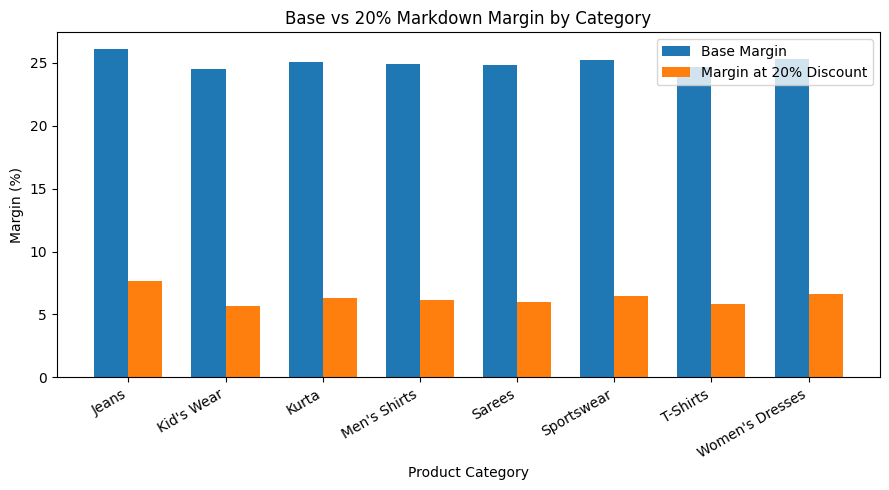

In [31]:
compare_20["margin_base"] = compare_20["total_profit"] / compare_20["total_revenue"]
compare_20["margin_20discount"] = compare_20["margin_after_disc"]

compare_20_plot = compare_20[["productCategory", "margin_base", "margin_20discount"]]

x = np.arange(len(compare_20_plot["productCategory"]))
width = 0.35

plt.figure(figsize=(9, 5))

plt.bar(x - width/2, compare_20_plot["margin_base"] * 100, width, label="Base Margin")
plt.bar(x + width/2, compare_20_plot["margin_20discount"] * 100, width, label="Margin at 20% Discount")

plt.xlabel("Product Category")
plt.ylabel("Margin (%)")
plt.title("Base vs 20% Markdown Margin by Category")
plt.xticks(x, compare_20_plot["productCategory"], rotation=30, ha="right")
plt.legend()
plt.tight_layout()
# plt.savefig("markdown_20_margin_by_category.png", dpi=300)
plt.show()

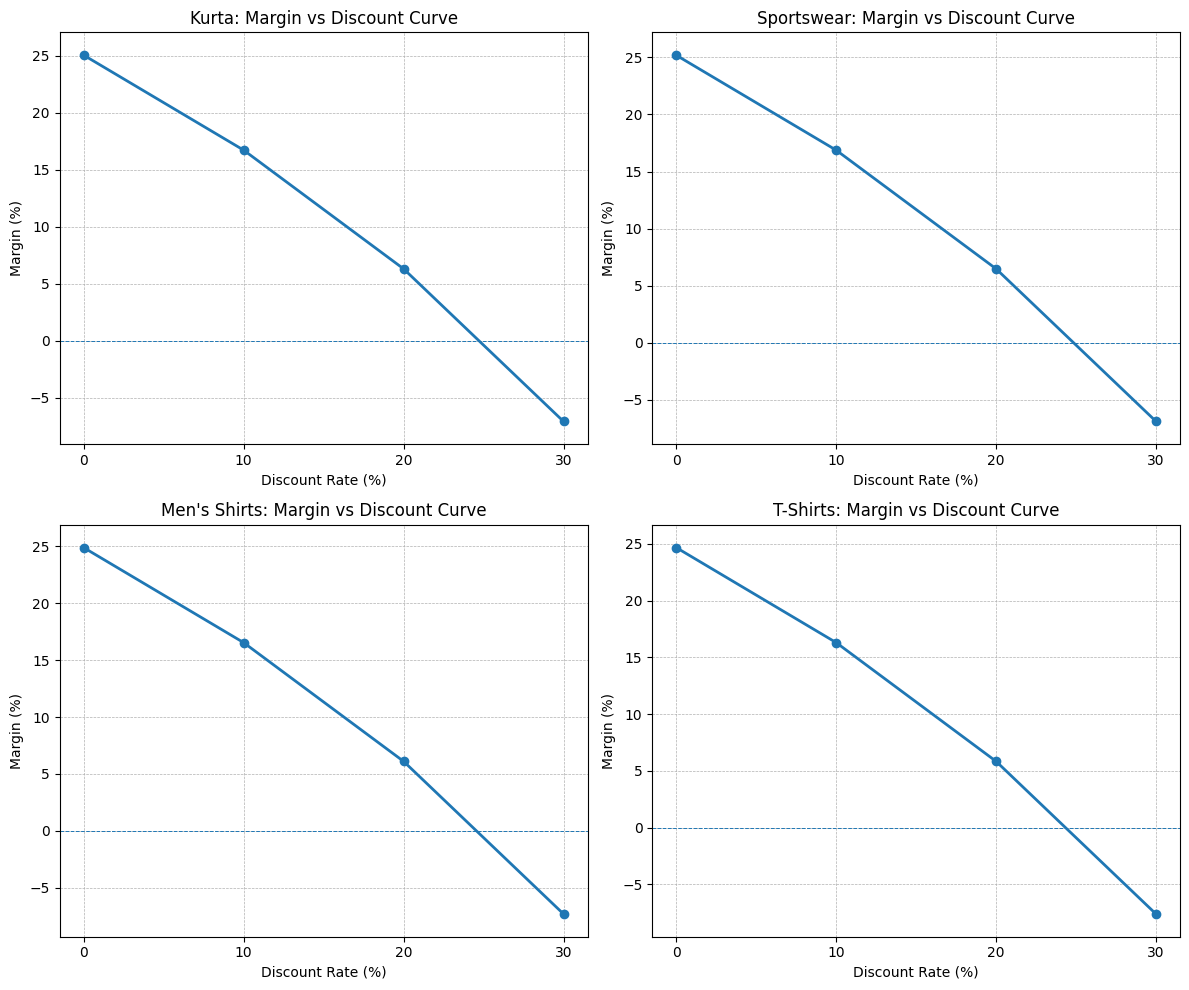

In [34]:
cat_base_df["base_margin_pct"] = cat_base_df["total_profit"] / cat_base_df["total_revenue"]

# Select top 4 categories by revenue for clarity
top_cats = (
    cat_base_df.sort_values("total_revenue", ascending=False)
    ["productCategory"]
    .head(4)
    .tolist()
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, cat in zip(axes, top_cats):
    base_margin = (
        cat_base_df.loc[cat_base_df["productCategory"] == cat, "base_margin_pct"]
        .iloc[0]
    )

    # Discounted margins (10, 20, 30%)
    sub = markdown_df[markdown_df["productCategory"] == cat].copy()
    sub = sub.sort_values("discount_rate")  # 0.10, 0.20, 0.30

    x_vals = [0] + list(sub["discount_rate"] * 100)              # [0, 10, 20, 30]
    y_vals = [base_margin * 100] + list(sub["margin_after_disc"] * 100)

    ax.plot(x_vals, y_vals, marker="o", linewidth=2)

    ax.set_title(f"{cat}: Margin vs Discount Curve")
    ax.set_xlabel("Discount Rate (%)")
    ax.set_ylabel("Margin (%)")

    y_min = min(y_vals) - 2
    y_max = max(y_vals) + 2
    ax.set_ylim(y_min, y_max)


    ax.set_xticks([0, 10, 20, 30])


    ax.axhline(0, linestyle="--", linewidth=0.7)

    ax.grid(True, linestyle="--", linewidth=0.5)


for i in range(len(top_cats), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig("markdown_margin_subplots.png", dpi=300)
plt.show()